In [2]:
using Plots
using Random
using LaTeXStrings
using Optim
using LazyGrids

rng = Xoshiro(14588); # set random number generator seed

In this notebook we are going to 

* solve a linear parameter identification problem with 
    * ordinary least squares (OLS) and 
    * prediction error method (PEM) as well as
* evaluate the found parameter sets in the cost-parameter plane.

Consider a simple first-order, discrete-time dynamic linear systems $$x[k+1] = \underbrace{\left(1+\frac{\Delta t}{\tau}\right)}_{a}x[k] + \underbrace{\left(V_{\mathrm{s}}\frac{\Delta t}{\tau}\right)}_{b}u[k] $$
which we already know from previous lectures. First, we will generate some simulated system response data including measurement noise.

In [3]:
Δt = 1; # time step width in s
Vs = 1; # Steady-state gain
τ = 15; # Time constant in s

a = (1-Δt/τ);
b = (Vs*Δt/τ);

# Generate input signal as multiple step functions towards +1 and -1 without a loop
N = 1000; # number of samples
u = zeros(N);
u[1:250] .= 1;
u[251:500] .= -1;
u[501:750] .= 1;
u[751:1000] .= -1;

# Generate output signal
x = zeros(N);
x[1] = 0;
for k = 2:N
    x[k] = a*x[k-1] + b*u[k-1];
end

# Add measurement noise to the states
σ = 0.1; # standard deviation of measurement noise
y = x + σ*randn(N); # add noise to the states and define measurement ouput y


Next, we will repeat our ordinary least squares (OLS) identification to showcase that this approach is not able to retrieve the original model parameters when measurement noise is present.

In [4]:
#set up an OLS problem to identify the parameters of the model
Y_OLS = y[2:end];
Z_OLS = [y[1:end-1] u[1:end-1]];
w_OLS = inv(Z_OLS'*Z_OLS)*Z_OLS'*Y_OLS

# Define a prediction function for the identified model parameters
function predict(w, u, N)
    x = zeros(N);
    for k = 2:N
        x[k] = w[1]*x[k-1] + w[2]*u[k-1];
    end
    return x
end

# Predict the states using the identified model parameters through the OLS approach
x_hat_OLS = predict(w_OLS, u, N);

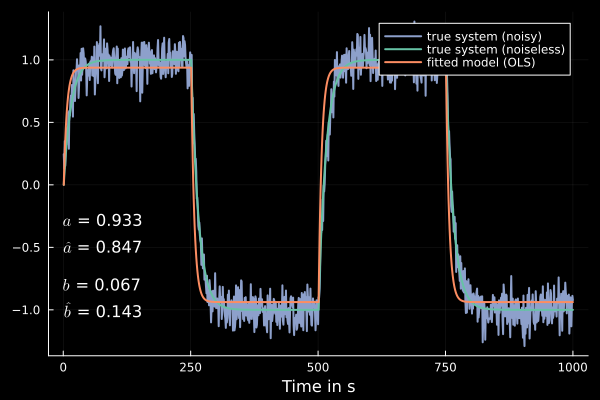

In [5]:
# plot the predicted model output via OLS vs. the ground truth data
plot(y, label="true system (noisy)",
lw=2, background_color="#000000",
grid=true, palette = :Set2_5, linecolor=3)
plot!(x, label="true system (noiseless)", lw=2, linecolor=1)
plot!(x_hat_OLS, label="fitted model (OLS)", lw=2, linecolor=2)

xlabel!("Time in s")

# add annotation box showing estimated parameter values
annotate!([(0, -0.5, text(L"$\hat{a}$ = %$(round(w_OLS[1]; digits = 3))", 
           11, :left, :white)),
           (0, -1.0, text(L"$\hat{b}$ = %$(round(w_OLS[2]; digits = 3))", 
           11, :left, :white))])

# add annotation box showing true parameter values
annotate!([(0, -0.3, text(L"$a$ = %$(round(a; digits = 3))",
           11, :left, :white)),
           (0, -0.8, text(L"$b$ = %$(round(b; digits = 3))", 
           11, :left, :white))])

To overcome the parameter estimation error, we will apply a direct parameter optimization using a dedicated optimization solver (in contrast to the closed-form linear algebra solution of OLS). 

For that, we start with defining a quadratic cost function for some unknown parameters $w$ inserted into our first-order model, that is, we are optimizing the parameters within a prediction model considering the entire input-output data trajectory (simulation considering the entire time span). This approach is known as the **prediction error method (PEM)**.

In [6]:
# Cost function with input arguments w (parameter -> opt. variable), u (input trajectory),  y (measurement data)
function costs(w, u, y)
    N = length(u)
    x = zeros(eltype(w), N); # initialize state vector
    for k = 2:N # simulate the system
        x[k] = w[1]*x[k-1] + w[2]*u[k-1];
    end
    return sum(abs2.(y .- x)) # return the sum of squared errors
end

costs (generic function with 1 method)

Next, we are using the [Optim](https://github.com/JuliaNLSolvers/Optim.jl/) package to find the PEM solution of the parameter vector using Newton's method.

In [7]:
res = optimize(w -> costs(w, u, y), [0.0, 0.0], Newton(); autodiff=:forward)

 * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     1.017816e+01

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 1.05e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.12e-11 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.88e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.73e-16 ≰ 0.0e+00
    |g(x)|                 = 5.03e-12 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    8
    f(x) calls:    36
    ∇f(x) calls:   36
    ∇²f(x) calls:  8


As the optimization solver converged successfully, we can print the model response using the newfound parameter vector based on the PEM optimization.

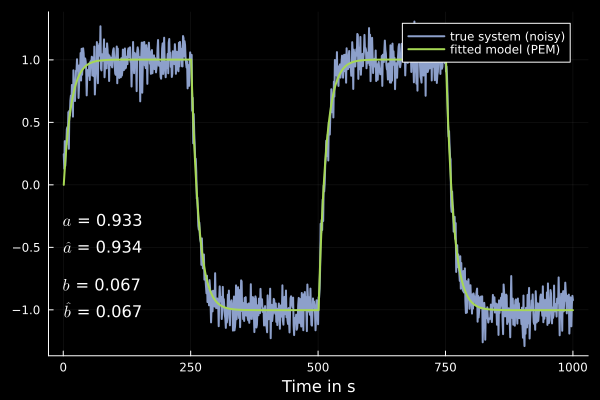

In [8]:
# plot the predicted direct LS model output vs. the ground truth data
plot(y, label="true system (noisy)",
lw=2, background_color="#000000",
grid=true, palette = :Set2_5, linecolor=3)

w_PEM = Optim.minimizer(res); # extract the optimal parameter values
plot!(predict(w_PEM, u, N), label="fitted model (PEM)", lw=2, linecolor=5) # plot the predicted model output

xlabel!("Time in s")

# add annotation box showing estimated parameter values
annotate!([(0, -0.5, text(L"$\hat{a}$ = %$(round(w_PEM[1]; digits = 3))", 
           11, :left, :white)),
           (0, -1.0, text(L"$\hat{b}$ = %$(round(w_PEM[2]; digits = 3))", 
           11, :left, :white))])

# add annotation box showing true parameter values
annotate!([(0, -0.3, text(L"$a$ = %$(round(a; digits = 3))",
           11, :left, :white)),
           (0, -0.8, text(L"$b$ = %$(round(b; digits = 3))", 
           11, :left, :white))])

Obviously, the PEM approach was able to find almost exactly the true model parameters. So, let's compare the found OLS and PEM solutions in a 2D contour landscape of the identification cost function. 

In [9]:
(a_vec, b_vec) = LinRange(0.8, 0.97, 100), LinRange(0.025, 0.25, 100) # define the parameter ranges
(ag, bg) = ndgrid(a_vec, b_vec) # define the grid of parameter values

costvalue = zeros(size(ag)) # initialize the cost function values for each parameter combination
for ii=1:length(ag) # loop over all parameter combinations
    costvalue[ii] = costs([ag[ii], bg[ii]], u, y) # evaluate the cost function for each parameter combination
end

For visualization purpose, we will cut out all 'poor' parameter combinations which led to irrelevant high cost values.

In [10]:
costvalue[costvalue .> 50] .= NaN;

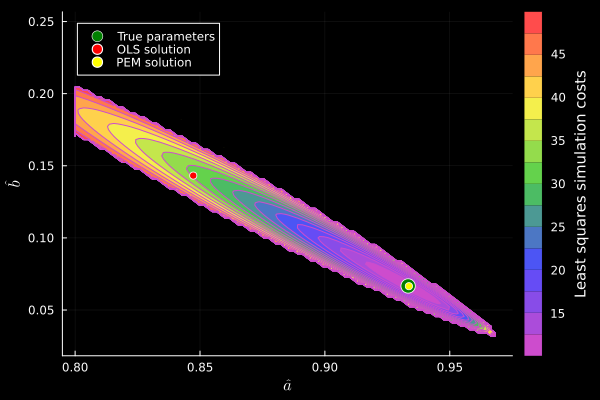

In [19]:
contourf(a_vec, b_vec, costvalue[:], levels=15, xlabel=L"$\hat{a}$", ylabel=L"$\hat{b}$", colorbar_title="Least squares simulation costs", background_color="#000000",colormap = :lightrainbow)
scatter!([a], [b], label="True parameters", color=:green, markersize = 8)
scatter!([w_OLS[1]], [w_OLS[2]] ,label="OLS solution", color=:red)
scatter!([w_PEM[1]], [w_PEM[2]], label="PEM solution", color=:yellow)